# Определение перспективного тарифа для телеком-компании

### Содержание


- [**Шаг 1. Общая информация о данных**](#part_1)
    - [1.1. Введение в проект](#101)
    - [1.2. Описание данных](#102)
    - [1.3. Выводы из общей информации о данных](#103)


- [**Шаг 2. Подготовка данных**](#part_2)
    - [2.1. Изменение типов данных](#201)
    - [2.2. Ошибки в данных](#202)
    - [2.3. Выводы из предобработки данных](#203)
    - [2.4. Подсчет для каждого пользователя](#204)
        - [2.4.1. Количество сделанных звонков и израсходованных минут разговора по месяцам](#2041)
        - [2.4.2. Количество отправленных сообщений по месяцам](#2042)
        - [2.4.3. Объем израсходованного интернет-трафика по месяцам](#2043)
        - [2.4.4. Помесячную выручку с каждого пользователя](#2044)


- [**Шаг 3. Анализ данных**](#part_3)
    - [3.1. Среднее количество, дисперсия и стандартное отклонение](#301)
    - [3.2. Гистограммы распределения](#302)
    - [3.3. Описательные статистики](#303)
    - [3.4. Выводы из анализа данных](#304)


- [**Шаг 4. Проверка гипотез**](#part_4)
    - [5.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#401)
    - [5.2. Средняя выручка пользователей из Моксвы отличается от выручки пользователей из других регионов](#402)
    - [5.3. Выводы из проверки гипотез](#403)


- [**Шаг 5. Общий вывод**](#part_5)

<a id='part_1'></a>
## Шаг 1. Общая информация о данных

<a id='101'></a>
### Введение в проект

В качестве аналитика федерального оператора сотовой связи необходимо сравнить два тарифа, «Смарт» и «Ультра», и выяснить, какой приносит больше денег. Доступна выборка из 500 клиентов за 2018 год.

<a id='102'></a>
### Описание данных

**Таблица users (информация о пользователях):**

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана


**Таблица calls (информация о звонках):**

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**

- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение


**Таблица internet (информация об интернет-сессиях):**
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя


**Таблица tariffs (информация о тарифах):**
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# вызов нужных библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import math

In [2]:
# чтение файлов с данными
original_users = pd.read_csv('/datasets/users.csv')
original_calls = pd.read_csv('/datasets/calls.csv')
original_messages = pd.read_csv('/datasets/messages.csv')
original_internet = pd.read_csv('/datasets/internet.csv')
original_tariffs = pd.read_csv('/datasets/tariffs.csv')

users = original_users.copy()
calls = original_calls.copy()
messages = original_messages.copy()
internet = original_internet.copy()
tariffs = original_tariffs.copy()

Данные о выборке распределены по пяти CSV-файлам. Для удобства вывода информации о них сделаем словарь с датафреймами:

In [3]:
# словарь с переменными, хранящими таблицы с данными, и одноименные ключи
datas_names = {'users': users, 
               'calls': calls, 
               'messages': messages, 
               'internet': internet, 
               'tariffs': tariffs}

По словарю выведем первые и последние строки каждой таблицы:

In [4]:
# вывод имени переменной с датафреймом и первых/последних строк датафрейма
for name, data in datas_names.items():
    display(name.upper())
    display(data)
    print()

'USERS'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


'CALLS'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


'MESSAGES'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


'INTERNET'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


'TARIFFS'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Вся информация получена на выборке из 500 клиентов — в таблице `users` с информацией о клиентах как раз 500 строк. Каждому пользователю присвоен уникальный номер, который также указан в таблицах `calls`, `messages`, `internet`; т.к. есть записи о множестве минут, сообщений и интернет-трафика, которые использовали клиенты, то номера продублированы, а каждому факту пользования услугой присвоен отдельный номер. Отдельно собраны условия тарифов, которые нужно оценить.

Из просмотра таблиц видно, что есть пропуски в `users.churn_date`, подозрительные нули в `calls.duration` и пока непонятный столбец `internet.Unnamed: 0`. Также известно, что минуты и мегабайты округляются до большего значения, а сейчас они указаны во `float`-формате — соответственно, их нужно будет округлить.

По словарю выведем общую информацию по всем таблицам:

In [5]:
# вывод имени переменной с датафреймом и информации о датафрейме
for name, data in datas_names.items():
    display(name.upper())
    display(data.info())
    print()

'USERS'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

'CALLS'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

'MESSAGES'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

'INTERNET'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

'TARIFFS'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

Из общей информации о таблицах видно, что пропуски в `users.churn_date` занимают большую часть столбца, а у столбцов с датами во всех таблицах неправильный тип данных. 

Важной задачей для анализа будет соединение данных из разных таблиц. В таблицах с данными об использованных минутах, сообщениях и интернет-трафике неодинаковое количество строк (что логично, ведь пользователи неодинаково пользуются разными услугами связи). Поэтому нужно проверить, все ли пользователи есть в этих таблицах. Для этого выведем длину столбца с уникальными значениями в столбце `user_id`, который есть во всех нужных таблицах:

In [6]:
for name in list(datas_names.keys())[:-1]:
    print('Пользователей в ' + name + ':', len(datas_names[name]['user_id'].value_counts()))

Пользователей в users: 500
Пользователей в calls: 492
Пользователей в messages: 426
Пользователей в internet: 497


Видно, что их неодинаковое количество — значит, при соединении таблиц ожидаются пропуски, которые нужно будет оставить. Чтобы не смешивать их с ошибками в исходных данных, сделаем объединенную таблицу после предобработки.

Также проверю странный столбец `internet.Unnamed: 0`:

In [7]:
display(internet['Unnamed: 0'])
internet.drop('Unnamed: 0', axis=1, inplace=True)

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

Очевидно, это продублированный индекс таблицы `internet`, этот столбец можно удалить.

Наконец, переименую некоторые названия столбцов для удобства:

In [8]:
# переименование столбцов
calls.columns = ['calls_id', 'call_date', 'duration', 'user_id']
messages.columns = ['messages_id', 'message_date', 'user_id']
internet.columns = ['internet_id', 'mb_used', 'session_date', 'user_id']

<a id='103'></a>
### Выводы из общей информации о данных

1. Похоже, что все данные соответствуют описанию.
1. На первый взгляд, нет полностью дублированных категорий.
1. Некоторые типы данных нужно изменить:
    - `users.reg_date` → `datetime64`
    - `users.churn_date` → `datetime64`
    - `calls.call_date` → `datetime64`
    - `messages.message_date` → `datetime64`
    - `internet.session_date` → `datetime64`
1. Есть пропуски в `users.churn_date` и подозрительные нули в `calls.duration`.
1. Также нужно сделать проверку на выбросы в числовых данных: `calls.duration` и `internet.mb_used`. В этих же столбцах данные во `float`-формате, по смыслу эти значения округляются до большего целого значения — следовательно, эти данные ещё не округлены.

<a id='part_2'></a>
## Шаг 2. Подготовка данных

<a id='201'></a>
### Изменение типов данных

Сначала переведем даты в нужный формат, чтобы к ним можно было примять специальные методы:

In [9]:
# перевод дат в datetime64
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

# проверка (без таблицы tariffs)
for name in list(datas_names.keys())[:-1]:
    display(name.upper())
    display(datas_names[name].dtypes)
    print()

'USERS'

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

'CALLS'

calls_id             object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

'MESSAGES'

messages_id             object
message_date    datetime64[ns]
user_id                  int64
dtype: object

'INTERNET'

internet_id             object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

Тип данных успешно изменен.
Исходя из описания данных, некорректными также являются все столбцы с `float`-форматом, но простой перевод в `int` здесь не подойдет. Сделаем нужные преобразования на следующих этапах.

<a id='202'></a>
### Ошибки в данных

Снова рассмотрим пропуски в `users.churn_date`:

In [10]:
# вывод всех пропусков в churn_date
users[users['churn_date'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
494,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart


Как уже было указано выше, эти пропуски занимают большую часть столбца `churn_date` — 462 из 500 строк. Однако известно, что эти пропуски не случайны: в столбце приведена дата прекращения пользования тарифом, а если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Какая-либо адекватная замена исходя из существующих данных невозможна. И хотя в таком виде эти данные мало помогут в анализе, их необходимо оставить без изменений.

Теперь изучим нули в `calls.duration` — рассмотрим объем нулей относительно всего столбца и их влияние на распределение данных:

In [11]:
# оценка объема нулей в столбце
print('Процент нулей в длительности звонков: {:.2%}'
      .format(len(calls[calls['duration'] == 0]) / len(calls)))
print('Количество звонков длиной в одну секунду:', len(calls[calls['duration'] == 1]))
print('Пользователей с нулевыми звонками:', len(calls[calls['duration'] == 0]['user_id'].value_counts()))
display(calls[calls['duration'] == 0])

Процент нулей в длительности звонков: 19.55%
Количество звонков длиной в одну секунду: 88
Пользователей с нулевыми звонками: 492


,calls_id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


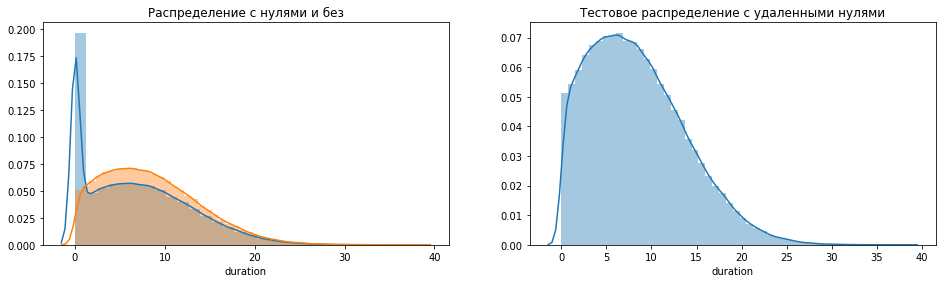

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# график текущего распределения столбца с нулями и без
ax = sns.distplot(calls['duration'], bins=30, ax=axs[0, 0])
sns.distplot(calls.query('duration > 0')['duration'], bins=50, ax=ax).set_title('Распределение с нулями и без')

# тестовое распределение при удалении нулей
calls_test = calls.copy()
calls_test = calls_test.drop(index=calls_test.loc[calls_test['duration'] == 0].index)
sns.distplot(calls_test['duration'], bins=50, ax=axs[0, 1]).set_title('Тестовое распределение с удаленными нулями')
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False);

На нули приходится почти 20% данных в столбце — это, конечно, много. На графиках распределения видно, что нули формируют пик, который искажает форму графика. Эти нули могут быть пропусками в результате технического сбоя, но остальные данные не формируют какой-то видимой закономерности, которая намекает на неслучайный характер предполагаемых пропусков. Более вероятно, что нули — это не пропуски, а очень короткие звонки, например, когда пользователи делали звонок и сразу сбрасывали его. Т.к. значения не округлены, эти нули сохранились в таблице.

Логично было бы их или удалить совсем, или округлить до единицы — правда, во втором случае наблюдаемый пик останется, сейчас количество звонков в 1 секунду слишком мало. На дальнейших этапах анализа при выведении количества потраченных в месяц минут 0 или 1 не внесут существенного вклада в итоговое число, но при нулях может возникнуть перекос в количестве звонков — звонок был, а в минутах это никак не выразилось. В то же время не до конца понятно, были ли эти звонки тарифицированы, чтобы оценить их реальное влияние на выручку. Поэтому кажется, что удаление из таблицы строк с нулями окажет наименьшее искажение на сгруппированные данные.

In [13]:
# удаление всех строк с нулями
calls = calls.drop(index=calls.loc[calls['duration'] == 0].index)

Такие же нули возможны и в `internet.mb_used`, проведем ту же процедуру для этого столбца:

In [14]:
# оценка объема нулей в столбце
print('Процент нулей в потраченном трафике: {:.2%}'
      .format(len(internet[internet['mb_used'] == 0]) / len(internet)))
print('Количество сессий в один мегабайт:', len(internet[internet['mb_used'] == 1]))
print('Пользователей с нулевыми сессиями:', len(internet[internet['mb_used'] == 0]['user_id'].value_counts()))
display(internet[internet['mb_used'] == 0])

Процент нулей в потраченном трафике: 13.12%
Количество сессий в один мегабайт: 1
Пользователей с нулевыми сессиями: 494


,internet_id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


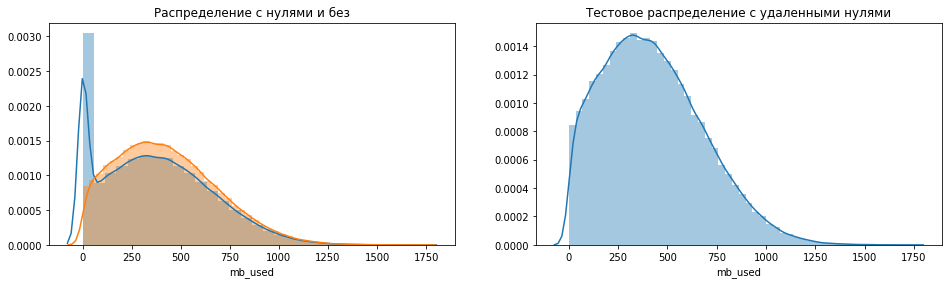

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# график текущего распределения столбца с нулями и без
ax = sns.distplot(internet['mb_used'], bins=30, ax=axs[0, 0])
sns.distplot(internet.query('mb_used > 0')['mb_used'], bins=50, ax=ax).set_title('Распределение с нулями и без')

# тестовое распределение при удалении нулей
internet_test = internet.copy()
internet_test = internet_test.drop(index=internet_test.loc[internet_test['mb_used'] == 0].index)
sns.distplot(internet_test['mb_used'], bins=50, ax=axs[0, 1]).set_title('Тестовое распределение с удаленными нулями')
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False);

Здесь видна та же ситуация, что и с длительностью звонков: нулей относительно много, более 13%, они образуют заметный пик на графике, всего одно ближайшее значение, и нули также распределены независимо от остальных данных в таблице. Похоже, нули зафиксировали некоторый сбой в подключении к интернету. Поскольку причины нулевых сессий кажутся схожими с причинами нулевых звонков, то можно принять аналогичное решение об удалении строк с нулями из таблицы. 

In [16]:
# удаление всех строк с нулями
internet = internet.drop(index=internet.loc[internet['mb_used'] == 0].index)

После очистки данных от нулей можно безопасно округлить эти столбцы до большего целого числа — в соответствии с тем, как происходила тарификация в реальности:

In [17]:
# округление минут и мегабайт до большего целого числа
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))
internet['mb_used'] = internet['mb_used'].apply(lambda x: math.ceil(x))

Теперь рассмотрим объем выбросов, они возможны в количественных данных `calls.duration` и `internet.mb_used`. На графиках выше уже заметен длинный хвост справа. Для фильтрации можно применить квантили или использовать правило трех сигм, если распределение данных соответствует нормальному. Визуально оба распределения ассиметричны, для надежности проверим распределение на нормальность тестом Д'Агостино-Пирсона (работает лучше на большой выборке):

In [18]:
def outliers_filter(data: 'df', column: 'string'):
    '''
    Функция нужна для фильтрации данных от выбросов;
    принимает в качестве аргумента датафрейм и название столбца, 
    проверяет распределение столбца на нормальность с помощью теста Д'Агостино-Пирсона; 
    
    если нулевая гипотеза о нормальности распределения не отвергается, 
    столбец фильтруется от выбросов на основе правила трех сигм;
    
    если нулевая гипотеза о нормальности распределения отвергается, 
    столбец фильтруется от выбросов по 1-му и 99-му процентилю;
    
    возвращает отфильтрованный столбец
    '''
    
    stat, p = st.normaltest(data[column])
    alpha = .05
    if p > alpha:
        return data.query(column+'.notna()')[data[column]
                                             .between(data[column].mean() - 3 * data[column].std(), 
                                                      data[column].mean() + 3 * data[column].std())][column]
    else:
        return data.query(column+'.notna()')[data[column]
                                             .between(data[column].quantile(.01), 
                                                      data[column].quantile(.99))][column]

Выбросов в duration: 0.93%
Выбросов в mb_used: 1.95%


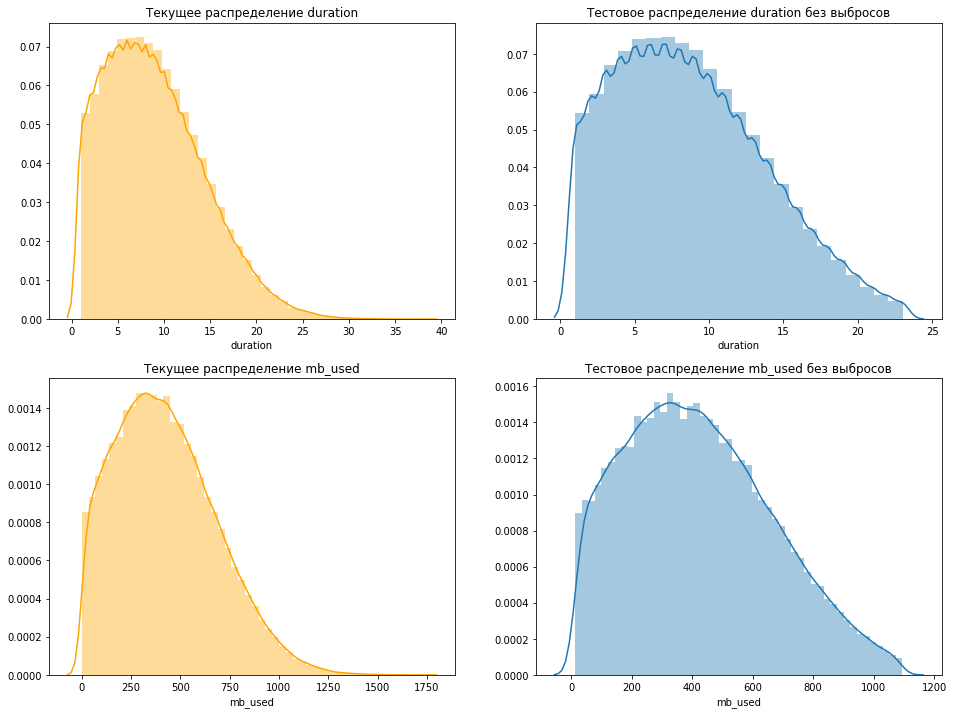

In [19]:
# 
print('Выбросов в duration: {:.2%}'.format(
    (len(calls['duration']) - len(outliers_filter(calls, 'duration'))) / len(calls['duration'])))
print('Выбросов в mb_used: {:.2%}'.format(
    (len(internet['mb_used']) - len(outliers_filter(internet, 'mb_used'))) / len(internet['mb_used'])))

# 
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 
sns.distplot(calls['duration'], bins=38, ax=axs[0, 0], color='orange').set_title('Текущее распределение duration')

calls_test = calls.copy()
calls_test = (calls_test
              .drop(index=calls_test
                    [~calls_test.index.isin(outliers_filter(calls_test, 'duration').index)].index))
sns.distplot(calls_test['duration'], 
             bins=23, 
             ax=axs[0, 1]).set_title('Тестовое распределение duration без выбросов')

# 
sns.distplot(internet['mb_used'], bins=50, ax=axs[1, 0], color='orange').set_title('Текущее распределение mb_used')

internet_test = internet.copy()
internet_test = (internet_test
                 .drop(index=internet_test
                       [~internet_test.index.isin(outliers_filter(internet_test, 'mb_used').index)].index))
sns.distplot(internet_test['mb_used'], 
             bins=50, 
             ax=axs[1, 1]).set_title('Тестовое распределение mb_used без выбросов');

В обоих столбцах на выбросы приходится небольшой процент; графики показывают, что распределение данных не нарушается, но отсекается хвост на высоких значениях. Поэтому кажется приемлимым удалить эти значения.

In [20]:
# удаление выбросов в столбцах duration и mb_used
calls = calls.drop(index=calls[~calls.index.isin(outliers_filter(calls, 'duration').index)].index)
internet = internet.drop(index=internet[~internet.index.isin(outliers_filter(internet, 'mb_used').index)].index)

In [21]:
# проверка на дубликаты во всех таблицах
for name, data in datas_names.items():
    print('Дубликатов в ' + name + ':', len(data[data.duplicated()]))

Дубликатов в users: 0
Дубликатов в calls: 0
Дубликатов в messages: 0
Дубликатов в internet: 0
Дубликатов в tariffs: 0


<a id='203'></a>
### Выводы из предобработки данных

1. Дубликатов в данных нет.
1. Некорректные типы данных переведены в нужный вид.
1. Пропуски в `users.churn_date` остались — для них нет адекватной замены.
1. Подозрительные нули в `calls.duration` и обнаруженные в `internet.mb_used` удалены из-за искажения данных.
1. Обнаружен небольшой процент выбросов в `calls.duration` и `internet.mb_used`, эти значения удалены.
1. Минуты и мегабайты округлены до большего целого значения в соответствии с правилами тарификации.

Теперь можно рассчитать помесячную выручку.

<a id='204'></a>
### Подсчет для каждого пользователя

<a id='2041'></a>
#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [22]:
# создание столбца с месяцем, в который сделан звонок
calls['call_month'] = pd.DatetimeIndex(calls['call_date']).month.astype(int)
calls['call_month'].value_counts(dropna=False)

12    27123
11    23434
10    21562
9     19267
8     17113
7     14637
6     11726
5     10036
4      7428
3      5325
2      2685
1      1149
Name: call_month, dtype: int64

In [23]:
# расчет количества звонков и потраченных минут каждым пользователем в месяц
calls_usage = calls.groupby(['user_id', 'call_month']).agg({'calls_id': 'count', 'duration': 'sum'}).reset_index()
calls_usage.columns = ['user_id', 'month', 'calls_per_month', 'minutes_per_month']
calls_usage

,user_id,month,calls_per_month,minutes_per_month
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,41,384
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,7,45
3165,1499,10,44,449
3166,1499,11,61,587


<a id='2042'></a>
#### Количество отправленных сообщений по месяцам

In [24]:
# создание столбца с месяцем, в который отправлено сообщение
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month.astype(int)
messages['message_month'].value_counts(dropna=False)

12    20555
11    18244
10    17114
9     14759
8     13088
7     11320
6      8983
5      7298
4      5179
3      3648
2      1924
1       924
Name: message_month, dtype: int64

In [25]:
# расчет количества отправленных сообщений каждым пользователем в месяц
messages_usage = messages.groupby(['user_id', 'message_month']).agg({'messages_id': 'count'}).reset_index()
messages_usage.columns = ['user_id', 'month', 'messages_per_month']
messages_usage

,user_id,month,messages_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


<a id='2043'></a>
#### Объем израсходованного интернет-трафика по месяцам

In [26]:
# создание столбца с месяцем, в который проведена интернет-сессия
internet['session_month'] = pd.DatetimeIndex(internet['session_date']).month.astype(int)
internet['session_month'].value_counts(dropna=False)

12    21086
11    18525
10    17018
9     14898
8     13738
7     11567
6      9463
5      8044
4      5575
3      4175
2      2227
1       956
Name: session_month, dtype: int64

In [27]:
# расчет количества потраченных мегабайт каждым пользователем в месяц
internet_usage = internet.groupby(['user_id', 'session_month']).agg({'mb_used': 'sum'}).reset_index()
internet_usage.columns = ['user_id', 'month', 'mb_per_month']
internet_usage

,user_id,month,mb_per_month
0,1000,5,2256
1,1000,6,22059
2,1000,7,14010
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20601
3197,1499,9,702
3198,1499,10,16624
3199,1499,11,15449


<a id='2044'></a>
#### Помесячную выручку с каждого пользователя

Высчитываем выручку следующим образом:
- вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
- остаток умножаем на значение из тарифного плана; 
- прибавляем абонентскую плату, соответствующую тарифному плану

In [28]:
# объединение в одну таблицу данных о помесячном использовании услуг связи, о пользователях и о тарифе
month_usage = (internet_usage.set_index(['user_id', 'month'])
               .join(messages_usage.set_index(['user_id', 'month']), how='outer')
               .join(calls_usage.set_index(['user_id', 'month']), how='outer')
               .reset_index().set_index('user_id')
               .join(users.set_index('user_id'), how='outer')
               .reset_index().set_index('tariff')
               .join(tariffs.set_index('tariff_name'), how='outer')
               .reset_index().rename(columns={'index':'tariff', 'mb_per_month_included': 'mb_included'}))

# упорядочивание столбцов
month_usage = month_usage[['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 
                           'tariff', 'minutes_included', 'messages_included', 'mb_included', 
                           'rub_monthly_fee', 'rub_per_minute', 'rub_per_message', 'rub_per_gb', 'month', 
                           'calls_per_month', 'minutes_per_month', 'messages_per_month', 'mb_per_month']]

# вывод итоговой таблицы
month_usage

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,minutes_included,messages_included,mb_included,rub_monthly_fee,rub_per_minute,rub_per_message,rub_per_gb,month,calls_per_month,minutes_per_month,messages_per_month,mb_per_month
0,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,500,50,15360,550,3,3,200,11.0,45.0,430.0,NaN,18452.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,500,50,15360,550,3,3,200,12.0,47.0,414.0,NaN,14053.0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,500,50,15360,550,3,3,200,6.0,14.0,117.0,4.0,10863.0
3,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,500,50,15360,550,3,3,200,7.0,20.0,187.0,11.0,17591.0
4,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,500,50,15360,550,3,3,200,8.0,37.0,289.0,13.0,20347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,3000,1000,30720,1950,1,1,150,8.0,13.0,92.0,13.0,1495.0
3212,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,3000,1000,30720,1950,1,1,150,9.0,95.0,813.0,82.0,32000.0
3213,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,3000,1000,30720,1950,1,1,150,10.0,125.0,1006.0,82.0,28260.0
3214,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,3000,1000,30720,1950,1,1,150,11.0,111.0,929.0,79.0,36750.0


In [29]:
month_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             3216 non-null   int64         
 1   age                 3216 non-null   int64         
 2   churn_date          189 non-null    datetime64[ns]
 3   city                3216 non-null   object        
 4   first_name          3216 non-null   object        
 5   last_name           3216 non-null   object        
 6   reg_date            3216 non-null   datetime64[ns]
 7   tariff              3216 non-null   object        
 8   minutes_included    3216 non-null   int64         
 9   messages_included   3216 non-null   int64         
 10  mb_included         3216 non-null   int64         
 11  rub_monthly_fee     3216 non-null   int64         
 12  rub_per_minute      3216 non-null   int64         
 13  rub_per_message     3216 non-null   int64       

В столбцах `calls_per_month`, `minutes_per_month`, `messages_per_month` и `mb_per_month` есть пропуски, но количество строк без пропусков соответствует длине отдельных таблиц с помесячным расходом минут, сообщений и интернет-трафика — поэтому заполнять пропуски здесь не имеет смысла.

Далее рассчитаем выручку с помощью функции и сохраним результат в отдельный столбец:

In [30]:
def calculate_revenue(row):
    '''
    Функция принимает в качестве аргумента строку из датафрейма,
    рассчитывает стоимость перерасхода минут, сообщений и интернет-трафика (если есть) для каждого клиента,
    возвращает сумму перерасхода и стоимости тарифа
    '''
    
    calls_spent = row['minutes_per_month']
    messages_spent = row['messages_per_month']
    internet_spent = row['mb_per_month']
    
    # подсчет перерасхода минут (если значение отрицательное, перерасход равен нулю)
    calls_extracost = calls_spent - row['minutes_included']
    if calls_extracost > 0:
        calls_extracost = calls_extracost * row['rub_per_minute']
    else:
        calls_extracost = 0
    
    # подсчет перерасхода сообщений (если значение отрицательное, перерасход равен нулю)
    messages_extracost = messages_spent - row['messages_included']
    if messages_extracost > 0:
        messages_extracost = messages_extracost * row['rub_per_message']
    else:
        messages_extracost = 0
    
    # подсчет перерасхода интернет-трафика (если значение отрицательное, перерасход равен нулю)
    # клиент платит за каждые дополнительные 1024 мегабайта, а не по значениям перерасхода
    internet_extracost = internet_spent - row['mb_included']
    if internet_extracost > 0:
        gb_extra = (internet_extracost // 1024) + 1
        internet_extracost = gb_extra * row['rub_per_gb']
    else:
        internet_extracost = 0
    
    # сумма перерасхода и стоимости тарифа
    return calls_extracost + messages_extracost + internet_extracost + row['rub_monthly_fee']

In [31]:
# создание столбца с помесячной выручкой
month_usage['month_revenue'] = month_usage.apply(calculate_revenue, axis=1)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(month_usage[['user_id', 'tariff', 'rub_monthly_fee', 'month', 'month_revenue']])

,user_id,tariff,rub_monthly_fee,month,month_revenue
0,1001,smart,550,11,1350
1,1001,smart,550,12,550
2,1002,smart,550,6,550
3,1002,smart,550,7,1150
4,1002,smart,550,8,1550
...,...,...,...,...,...
3211,1495,ultra,1950,8,1950
3212,1495,ultra,1950,9,2250
3213,1495,ultra,1950,10,1950
3214,1495,ultra,1950,11,2850


In [32]:
month_usage['month_revenue'].value_counts()

1950.0    928
550.0     592
950.0      99
1350.0     86
750.0      81
         ... 
1934.0      1
1282.0      1
1083.0      1
989.0       1
2247.0      1
Name: month_revenue, Length: 732, dtype: int64

В столбце большая часть значений приходится на 1950 рублей и 550 рублей в соответствии со стоимостью тарифов в месяц — это выручка с пользователей, которые не превысили лимитов связи внутри тарифа.

<a id='part_3'></a>
## Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Для оценки количества минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц посчитаем среднее количество, дисперсию и стандартное отклонение, построим гистограммы и выведем описательные статистики.

<a id='301'></a>
### Среднее количество, дисперсия и стандартное отклонение

In [33]:
# среднее, дисперсия и стандартное отклонение данных о минутах, сообщениях и интернет-трафике 
# в зависимости от тарифа
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(month_usage[['tariff', 'minutes_per_month', 'messages_per_month', 'mb_per_month']]
            .groupby('tariff').agg(['mean', 'var', 'std']))

minutes_per_month                 messages_per_month                \
                    mean      var    std               mean     var   std   
tariff                                                                      
smart             408.41 33950.54 184.26              38.72  717.59 26.79   
ultra             532.37 88527.75 297.54              61.16 2109.66 45.93   

       mb_per_month                      
               mean         var     std  
tariff                                   
smart      16018.58 33330220.56 5773.23  
ultra      18613.30 88510408.58 9408.00

In [34]:
# среднее, дисперсия и стандартное отклонение данных о минутах, сообщениях и интернет-трафике 
# в зависимости от тарифа и месяца
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(month_usage[['tariff', 'month', 'minutes_per_month', 'messages_per_month', 'mb_per_month']]
            .groupby(['tariff', 'month']).agg(['mean', 'var', 'std']))

minutes_per_month                  messages_per_month          \
                          mean       var    std               mean     var   
tariff month                                                                 
smart  1.00             203.94  22019.25 148.39              20.00  252.13   
       2.00             291.88  36310.74 190.55              27.94  440.47   
       3.00             381.14  35509.55 188.44              35.55  669.78   
       4.00             361.95  31993.54 178.87              35.86  517.87   
       5.00             379.57  33604.33 183.31              39.03  638.78   
       6.00             388.08  28846.75 169.84              38.58  731.64   
       7.00             397.05  30713.41 175.25              38.99  719.35   
       8.00             412.50  32483.28 180.23              38.75  767.21   
       9.00             418.66  31465.70 177.39              39.22  702.51   
       10.00            416.84  33425.70 182.83              39.08  736.50   
       11.00            423.87  28858.77 169.88              39.88  711.36   
       12.00            466.34  37071.73 192.54              42.26  832.45   
ultra  1.00             408.67  65579.50 256.08              43.43  765.29   
       2.00             304.70  82680.68 287.54              32.94  713.40   
       3.00             468.41 104259.25 322.89              47.80 1826.67   
       4.00             455.42  60498.40 245.96              44.51 1408.26   
       5.00             519.25  71317.05 267.05              48.77 1559.55   
       6.00             483.22  80645.82 283.98              52.31 1935.67   
       7.00             554.72  79355.06 281.70              62.14 2190.73   
       8.00             524.26  85189.86 291.87              58.90 2022.97   
       9.00             549.08  91969.12 303.26              63.29 1906.76   
       10.00            565.82  92254.71 303.73              69.78 2426.61   
       11.00            546.68  84881.06 291.34              66.16 2249.30   
       12.00            598.54 102405.44 320.01              72.01 2362.87   

                   mb_per_month                        
               std         mean          var      std  
tariff month                                           
smart  1.00  15.88      8490.56  41767453.34  6462.77  
       2.00  20.99     11445.91  37614273.03  6133.05  
       3.00  25.88     14932.78  33306012.57  5771.14  
       4.00  22.76     13348.41  32347133.60  5687.45  
       5.00  25.27     15546.91  35770586.18  5980.85  
       6.00  27.05     15602.26  32655566.31  5714.50  
       7.00  26.82     15615.17  34729919.00  5893.21  
       8.00  27.70     16472.41  29183190.67  5402.15  
       9.00  26.50     16092.43  25932511.03  5092.40  
       10.00 27.14     16534.73  32440496.10  5695.66  
       11.00 26.67     16687.91  27671144.02  5260.34  
       12.00 28.85     17892.61  29740528.13  5453.49  
ultra  1.00  27.66     12614.56  42116714.28  6489.74  
       2.00  26.71     12090.00 101889675.05 10094.04  
       3.00  42.74     16610.41 109644851.69 10471.14  
       4.00  37.53     15755.71  84767064.73  9206.90  
       5.00  39.49     18983.68  88617120.66  9413.67  
       6.00  44.00     17974.20  79540103.80  8918.53  
       7.00  46.81     19565.64  83851655.87  9157.05  
       8.00  44.98     18708.40  93448665.80  9666.89  
       9.00  43.67     18431.68  77341568.45  8794.41  
       10.00 49.26     19100.38  86757606.29  9314.38  
       11.00 47.43     18754.36  84227742.78  9177.57  
       12.00 48.61     20819.67  92008868.94  9592.13

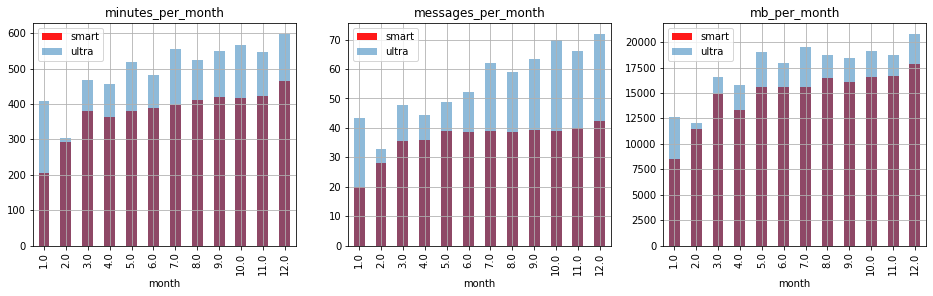

In [35]:
# столбцовые графики средних затрат минут, сообщений и интернет-трафика в зависимости от тарифа
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
i = 0
for column in ['minutes_per_month', 'messages_per_month', 'mb_per_month']:
    ax = (month_usage
          .query('tariff == "smart"')
          .pivot_table(index='month', values=column)
          .plot(kind='bar', alpha=0.9, ax=axs[0, i], colormap='autumn'))
    (month_usage
     .query('tariff == "ultra"')
     .pivot_table(index='month', values=column)
     .plot(kind='bar', alpha=0.5, ax=ax, grid=True, legend=True)
     .set_title(column))
    ax.legend(['smart', 'ultra'])
    i += 1
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False)
axs.flat[-3].set_visible(False);

<a id='302'></a>
### Гистограммы распределения

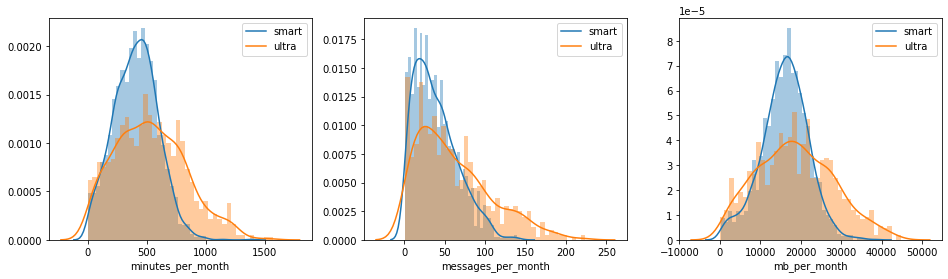

In [36]:
# распределение данных о минутах, сообщениях и интернет-трафике в зависимости от тарифа
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
i = 0
for column in ['minutes_per_month', 'messages_per_month', 'mb_per_month']:
    sns.distplot(month_usage.query('tariff == "smart"')[column], bins=40, ax=axs[0, i], kde_kws={'label':'smart'})
    sns.distplot(month_usage.query('tariff == "ultra"')[column], bins=40, ax=axs[0, i], kde_kws={'label':'ultra'})
    i += 1
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False)
axs.flat[-3].set_visible(False);

In [37]:
# тест Шапиро-Уилка для каждой услуги каждого тарифа
for column in ['minutes_per_month', 'messages_per_month', 'mb_per_month']:
    for index, values in month_usage.groupby('tariff')[column]:
        alpha = .05
        stats, p = st.shapiro(month_usage[month_usage[column].notna()][column])
        if p < alpha:
            print('Не соответствует нормальному распределению:', index+',', column)
        else:
            print('Соответствует нормальному распределению:', index+',', column)
    print()

Не соответствует нормальному распределению: smart, minutes_per_month
Не соответствует нормальному распределению: ultra, minutes_per_month

Не соответствует нормальному распределению: smart, messages_per_month
Не соответствует нормальному распределению: ultra, messages_per_month

Не соответствует нормальному распределению: smart, mb_per_month
Не соответствует нормальному распределению: ultra, mb_per_month



In [38]:
# тест ассиметричности распределения для каждой услуги каждого тарифа
for column in ['minutes_per_month', 'messages_per_month', 'mb_per_month']:
    for index, values in month_usage.groupby('tariff')[column]:
        alpha = .05
        stats, p = st.skewtest(month_usage[month_usage[column].notna()][column])
        if p < alpha:
            print('Есть ассиметрия:', index+',', column)
        else:
            print('Нет ассиметрии:', index+',', column)
    print()

Есть ассиметрия: smart, minutes_per_month
Есть ассиметрия: ultra, minutes_per_month

Есть ассиметрия: smart, messages_per_month
Есть ассиметрия: ultra, messages_per_month

Есть ассиметрия: smart, mb_per_month
Есть ассиметрия: ultra, mb_per_month



In [39]:
# тест эксцесса распределения для каждой услуги каждого тарифа
for column in ['minutes_per_month', 'messages_per_month', 'mb_per_month']:
    for index, values in month_usage.groupby('tariff')[column]:
        alpha = .05
        stats, p = st.kurtosistest(month_usage[month_usage[column].notna()][column])
        if p < alpha:
            print('Есть эксцесс:', index+',', column)
        else:
            print('Нет эксцесса:', index+',', column)
    print()

Есть эксцесс: smart, minutes_per_month
Есть эксцесс: ultra, minutes_per_month

Есть эксцесс: smart, messages_per_month
Есть эксцесс: ultra, messages_per_month

Есть эксцесс: smart, mb_per_month
Есть эксцесс: ultra, mb_per_month



<a id='303'></a>
###  Описательные статистики

In [40]:
# описательные статистики данных о минутах, сообщениях и интернет-трафике в зависимости от тарифа
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(
        month_usage
        .query('tariff == "smart"')[['minutes_per_month', 'messages_per_month', 'mb_per_month']]
        .describe()
        .join(month_usage
              .query('tariff == "ultra"')[['minutes_per_month', 'messages_per_month', 'mb_per_month']]
              .describe(), lsuffix = '_smart', rsuffix = '_ultra')
    )

,minutes_per_month_smart,messages_per_month_smart,mb_per_month_smart,minutes_per_month_ultra,messages_per_month_ultra,mb_per_month_ultra
count,2221.00,1922.00,2227.00,947.00,795.00,974.00
mean,408.41,38.72,16018.58,532.37,61.16,18613.30
std,184.26,26.79,5773.23,297.54,45.93,9408.00
min,2.00,1.00,202.00,1.00,1.00,24.00
25%,275.00,17.00,12515.50,306.00,24.00,11305.25
50%,412.00,34.00,16248.00,513.00,51.00,18327.50
75%,533.00,55.00,19805.00,743.50,87.50,25444.50
max,1386.00,143.00,38610.00,1568.00,224.00,44776.00


<a id='304'></a>
### Выводы из анализа данных

Из таблиц и графиков мы видим следующее:

1. Пользователи «Ультры» потребляют больше услуг связи, как в целом, так и по месяцам.
1. Разница в потреблении интернет-трафика между пользователями разных тарифов меньше, чем в потреблении минут и сообщений.
1. Есть тенденция к росту потребления услуг связи в течение года: для всех тарифов в январе тратят меньше всего, в декабре больше всего.
1. Пользователи «Смарта» в основном укладываются в лимиты минут и сообщений, в то же время больше половины не укладываются в лимит интернет-трафика. Пользователи «Ультры» совсем не превышают лимиты минут и сообщений, большинство укладывается в лимит трафика.
1. Данные о минутах, сообщениях и интернет-трафике для обоих тарифов не соответствуют нормальному распределению; графики подтверждают выводы предыдущего пункта: 
    - наиболее заметна правосторонняя ассиметрия данных о сообщениях: большинство значений собраны от 0 до 55 для «Смарта», от 0 до 87 для «Ультры». Можно сделать вывод, что пользователи при наличии мобильного интернета и мессенджеров отправляют не очень много СМС. Конечно, дополнительно доступные на «Ультре» 950 сообщений побуждают клиентов этого тарифа отправлять больше сообщений, но им далеко до превышения лимита;
    - распределение данных о минутах и сообщениях между тарифами показывает, что пользователи «Смарта» менее активно пользуются услугами связи в целом или по крайней мере стараются не переплачивать за связь (конечно, здесь разница в стоимости и условиях тарифа очень значительная), но данные об интернет-трафике при этом визуально ближе к нормальному распределению — похоже, что на интернет более стабильный спрос;
    - также видно, что значение на нижней границе меквартильного размаха данных о потреблении интернет-трафика пользователями «Смарта» всего на 2,4 Гб ниже лимита, среднее и медианное значения уже выше лимита; можно снова сделать вывод о высоком спросе на интернет-трафик и регулярной нехватке включенного в «Смарт» трафика.


Кажется ожидаемым, что на тарифе «Ультра» тратят больше минут, сообщений и мегабайт — там больше лимиты и он стоит значительно дороже, выбор должен быть оправданным. Но кажется, что разница в потреблении услуг не очень велика: тариф «Ультра», который стоит почти в 4 раза дороже, предлагает в 6 раз больше минут, в 20 раз больше сообщений и в 2 раза больше интернет-трафика — и мы, конечно, не видим таких различий. Наибольший спрос — на интернет-трафик, что опять же ожидаемо для 2018: если допустить, что в большинстве это пользователи мобильных устройств, то потребление информации, текстовая и голосовая коммуникация в основном ведется через интернет и требует интернет-трафика; рост скорости доступа в интернет также побуждает больше им пользоваться.

Также на предыдущем этапе выяснилось, что клиенты «Ультры» полностью укладываются в лимиты примерно на 60% чаще клиентов со «Смартом» — похоже, это также связано с объемом потребляемых услуг связи в целом.

<a id='part_4'></a>
## Шаг 4. Проверка гипотез

Теперь сравним среднюю выручку по тарифам и локациям, для чего необходимо также выяснить, не является ли наблюдаемое различие в средних значениях случайным. В зависимости от характера распределения данных о выручке выберем параметрический t-тест Стьюдента или непараметрический U-критерий Манна-Уитни. Для выбора теста используем функцию, включающую в себя тест Шапиро-Уилка.

In [41]:
def equal_var_test(sample_1: 'Series', sample_2: 'Series'):
    '''
    Функция нужна для настройки t-теста на равенство средних;
    она принимает в качестве аргумента 2 Series, 
    проверяет равенство их дисперсий с помощью теста Левена, 
    возвращает булево значение результата сравнения p-значения с заданным уровнем значимости
    '''
    
    levene = st.levene(sample_1, sample_2)
    alpha = .01
    if levene.pvalue < alpha:
        return False
    else:
        return True

In [42]:
def equal_mean_test(sample_1: 'Series', sample_2: 'Series'):
    '''
    Функция нужна для выбора теста на проверку равенства двух средних в зависимости от распределения;
    она принимает в качестве аргумента 2 Series, 
    проверяет нормальность распределения тестом Шапиро-Уилка;
    
    если нулевая гипотеза о нормальности распределения отвергается, 
    равенство средних проверяется тестом Манна-Уитни;
    
    если нулевая гипотеза о нормальности распределения не отвергается, 
    равенство средних проверяется t-тестом Стьюдента;
    
    в результате выводит на экран p-значение выбранного теста и результат сравнения с заданным уровнем значимости 
    '''
    
    # тест Шапиро-Уилка на соответствие распределения нормальному
    shapiro_stat_1, shapiro_p_1 = st.shapiro(sample_1)
    shapiro_stat_2, shapiro_p_2 = st.shapiro(sample_2)
    alpha = .05
    
    # гипотеза о нормальности распределения отвергается, используем тест Манна-Уитни
    if shapiro_p_1 < alpha and shapiro_p_2 < alpha:
        print('Отвергаем нулевую гипотезу о соответствии нормальному распределению')
        print('p-значение первой выборки (тест Шапиро-Уилка): {:.2f}'.format(shapiro_p_1))
        print('p-значение второй выборки (тест Шапиро-Уилка): {:.2f}'.format(shapiro_p_2))
        print()
        u_alpha = .01
        u_results = st.mannwhitneyu(sample_1, sample_2, alternative='two-sided')
        print('p-значение (U-тест Манна-Уитни): {:.10f}'.format(u_results.pvalue))
        if u_results.pvalue < u_alpha:
            print('Отвергаем нулевую гипотезу о равенстве средних')
        else:
            print('Не получилось отвергнуть нулевую гипотезу о равенстве средних')
    
    # гипотеза о нормальности распределения не отвергается, используем t-тест Стьюдента
    if shapiro_p_1 >= alpha and shapiro_p_2 >= alpha:
        print('Не получилось отвергнуть нулевую гипотезу о соответствии нормальному распределению')
        print('p-значение первой выборки (тест Шапиро-Уилка): {:.2f}'.format(shapiro_p_1))
        print('p-значение второй выборки (тест Шапиро-Уилка): {:.2f}'.format(shapiro_p_2))
        print()
        t_alpha = .01
        equal_var = equal_var_test(sample_1, sample_2) # функция использует тест Левена
        t_results = st.ttest_ind(sample_1, sample_2, equal_var=equal_var)
        print('p-значение: {:.10f}'.format(t_results.pvalue))
        print('Равенство дисперсий', equal_var)
        if t_results.pvalue < t_alpha:
            print('Отвергаем нулевую гипотезу о равенстве средних')
        else:
            print('Не получилось отвергнуть нулевую гипотезу о равенстве средних')

<a id='401'></a>
### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Здесь мы проверям статистическую гипотезу о равенстве средних значений помесячной выручки пользователей разных тарифов.
- Нулевая гипотеза — средние значения выручки пользователей разных тарифов равны.
- Альтернативная гипотеза — что средние значения выручки пользователей разных тарифов различаются.

Для проверки гипотезы используем функцию для выбора критерия проверки средних на основе теста распределения `month_revenue`.

In [43]:
revenue_smart = month_usage.query('tariff == "smart"')['month_revenue']
revenue_ultra = month_usage.query('tariff == "ultra"')['month_revenue']

# применение функции по выбору теста для сравнения двух средних независимых выборок
equal_mean_test(revenue_smart, revenue_ultra)
print()
print('Средняя выручка «Смарт»: {:.2f} руб.'.format(revenue_smart.mean()))
print('Средняя выручка «Ультра»: {:.2f} руб.'.format(revenue_ultra.mean()))

Отвергаем нулевую гипотезу о соответствии нормальному распределению
p-значение первой выборки (тест Шапиро-Уилка): 0.00
p-значение второй выборки (тест Шапиро-Уилка): 0.00

p-значение (U-тест Манна-Уитни): 0.0000000000
Отвергаем нулевую гипотезу о равенстве средних

Средняя выручка «Смарт»: 1244.50 руб.
Средняя выручка «Ультра»: 2030.63 руб.


Уровень значимости позволяет сделать обоснованное допущение, что средние значения помесячной выручки пользователей разных тарифов имеют значимые различия; более того, с таким p-значением для текущих данных шанс случайно получить различия в средних близок к невозможному. Соответственно, делаем вывод, что средняя выручка между тарифами действительно различается: оператор в 2018 заработал с пользователей тарифа «Ультра» почти на 63% больше.

<a id='402'></a>
### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Здесь мы проверям статистическую гипотезу о равенстве средних значений помесячной выручки пользователей из Москвы и регионов.
- Нулевая гипотеза — средние значения выручки пользователей из Москвы и регионов равны.
- Альтернативная гипотеза — что средние значения выручки пользователей из Москвы и регионов различаются.

Для проверки гипотезы используем функцию для выбора критерия проверки средних на основе теста распределения `month_revenue`.

In [44]:
revenue_moscow = month_usage.query('city == "Москва"')['month_revenue']
revenue_regions = month_usage.query('city != "Москва"')['month_revenue']

# применение функции по выбору теста для сравнения двух средних независимых выборок
equal_mean_test(revenue_moscow, revenue_regions)
print()
print('Средняя выручка в Москве: {:.2f} руб.'.format(revenue_moscow.mean()))
print('Средняя выручка в регионах: {:.2f} руб.'.format(revenue_regions.mean()))

Отвергаем нулевую гипотезу о соответствии нормальному распределению
p-значение первой выборки (тест Шапиро-Уилка): 0.00
p-значение второй выборки (тест Шапиро-Уилка): 0.00

p-значение (U-тест Манна-Уитни): 0.2612919130
Не получилось отвергнуть нулевую гипотезу о равенстве средних

Средняя выручка в Москве: 1507.49 руб.
Средняя выручка в регионах: 1480.37 руб.


Согласно p-значению, с вероятностью более 26% наблюдаемое или большее различие в средних значениях можно получить случайно. Соответственно, на основании этих данных мы не можем сделать вывод о какой-либо разнице в полученной за 2018 год выручке между Москвой и регионами.

<a id='403'></a>
### Выводы из проверки гипотез

Соответствие или несоответствие распределения данных о выручке нормальному виду побуждает использовать параметрические или непараметрические критерии для сравнения двух средних независимых выборок соответственно. Похоже, что данные согласно тесту Шапиро-Уилка не были распределены нормально, поэтому для проверки равенства двух средних использовался непараметрический U-критерий Манна-Уитни (впрочем, даже при использовании здесь t-теста Стьюдента выводы по гипотезам остаются теми же).

В результате проверки оказалось, что мы можем сделать обоснованный вывод о различии средней выручки пользователей двух тарифов: на пользователях «Ультры» можно заработать на 63% больше. А вывод о разнице между средней выручкой в Москве и регионах мы сделать исходя из текущих данных не можем.

<a id='part_5'></a>
## Шаг 5. Общий вывод

Вспомним, что цель этого исследования — выяснить, какой тариф, «Смарт» или «Ультра», приносит больше денег. Это нужно, чтобы скорректировать рекламный бюджет. Для прояснения ситуации мы использовали данные выборки из 500 клиентов «Мегалайна» за 2018 год, куда была включена информация самих клиентах, о дате их каждых звонка, сообщения и интернет-сессии, о длительности каждого разговора и о количестве потраченных за каждую интернет-сессию мегабайт. Это позволило проанализировать поведение клиентов и сделать следующие выводы:

1. Как и было указано выше, пользователи «Ультры» приносят примерно на 63% больше денег, что делает этот тариф более перспективным. При этом есть основания считать, что большую прибыль приносит помесячная оплата тарифа, а не дополнительная покупка услуг связи: клиенты «Ультры», хоть и пользуются связью больше, в основном укладываются в лимиты тарифа — на 60% чаще пользователей «Смарта».
1. Для сравнения выручки между Москвой и регионами недостаточно данных.
1. Можно констатировать, что для пользователей обоих тарифов спрос на интернет-трафик заметно выше: в частности, это заставило пользователей «Смарта» в 2018 году в среднем 9 из 12 месяцев докупать трафик сверх лимита. Большинству пользователей «Ультры» хватает трафика в рамках тарифа.
1. Звонки и сообщения пользуются меньшим спросом (особенно сообщения): пользователи «Смарта» превышают эти лимиты редко, пользователи «Ультры» — никогда.
1. Использование всех услуг связи на всех тарифах имеет тенденцию расти в течение года; в январе тратят меньше всего, а в декабре — больше всего.